# Automatic row selection during model training

## Introduction to the problem

*A lot of time is spent during model training engineering and selecting features. 

*However, in a dataset there can be not only column-wise noise but also row-wise noise. There can be rows where the information collected is of bad quality and they can worsen the model trained through forcing the model to overfit the noise to reduce the error. This overfitting creates less generalizable models.

*It is good to have as much data as possible but it is also  necessary to find the right balance between amount and quality of data. There are some methods to preprocess data to reduce this noise or to find rows behaving as outliers (and then should be removed). However, these methods would need the onehot encoding of categorical data (with its caveats) and they seem not to be usable in non-tabular data (e.g. for image selection).

*Some methods of feature selection are based on achieving information during model training to decide which features to keep or not. However, as far as I am concerned, there are no methods to try to take advantage in an automatic manner of the information collected during model training. Probably this is caused by the lack of reliability of the residuals found during model training (because of the overfitting of noise).

*However, if one performs bootstrapping during model training and saves the predictions, one can analyze in which rows the prediction will be of worse quality. If for all bootstrap iterations the prediction was of bad quality, this will be an indicator that the prediction is failing not because of the bad model quality but because thsi row does not behave  as most other ones. Hence, this row is noisy and its removal might benefit the quality of the models achieved.

In [1]:
library(caret)
library(mlbench)
library(dplyr)
data(BostonHousing)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Creation of training split.

In [2]:
set.seed(1);train_ind=createDataPartition(BostonHousing$medv, p=0.75)[[1]]


Training of model with .632 bootstrap with 1000 iterations, saving all predictions.

In [3]:
set.seed(1);model <- train(medv ~ . ,
               data = BostonHousing[train_ind,],
               preProcess = c("center", "scale"),
               method = "lasso",
               metric="MAE",
               tuneLength = 10,
               trControl = trainControl(method = "boot632",number=1000,
                                        savePredictions = "all"))

In [61]:
MAE(pred = predict(model,BostonHousing[-train_ind,]),obs=BostonHousing$medv[-train_ind])

[1] 3.397312

# Row selection according to bootstrapping information

* In each the bootstrap iteration during model training, a subset of rows is selected to predict in the other subset of rows.

* Theoretically, trained models during each bootstrapping iteration should be highly similar as they are analyzing similar information. If there are rows where the error estimated during prediction tends to be high, it is probable that the error is not caused by the model but by the noise present in the data in the row.

* Removing rows with high error during prediction might improve models. Less noise is present in the training data then model optimization can focus better on the right weighting of the informative features and can avoid the overfititng of noise. As aresult, the models trained can be more generalizable to test data.

1. Calculation of residual between predicted and observed value during all bootstrapping iterations.
2. Calculation of mean residual for each row.

In [8]:
model$pred$MAE=abs(model$pred$pred-model$pred$obs)

bootstrap_residual_stats = model$pred %>%
group_by(rowIndex) %>%
summarise(mean = mean(MAE,na.rm=T),sd=sd(MAE,na.rm=T))
summary(bootstrap_residual_stats)

    rowIndex        mean               sd        
 Min.   :  1   Min.   : 0.5519   Min.   :0.3891  
 1st Qu.: 96   1st Qu.: 1.6584   1st Qu.:0.8293  
 Median :191   Median : 2.6968   Median :1.3508  
 Mean   :191   Mean   : 3.9218   Mean   :1.6558  
 3rd Qu.:286   3rd Qu.: 4.5555   3rd Qu.:2.0971  
 Max.   :381   Max.   :29.5058   Max.   :6.2696  

Function which estimates MAE in test split depending on the rows selected.

In [67]:
fr <- function(x) {
   set.seed(1);model=train(medv ~ . ,
                             data = BostonHousing[train_ind,][error_order[1:x],],
                             preProcess = c("center", "scale"),
                             method = "lasso",
                             metric="MAE",
                             tuneLength = 10,
                             trControl = trainControl(method = "boot632",
                                                      savePredictions = "all"))
  MAE(pred = predict(model,BostonHousing[-train_ind,]),obs=BostonHousing$medv[-train_ind])
  
}


Preparation of sequence of number of rows to use during model training.

In [9]:
no_rows_sequence=seq(length(train_ind),length(train_ind)-100,-5)

1. Ordering of rows depending on MAE calculated for each row in bootstrap iterations.
2. Calculation of MAE in test split depending on number of rows selected.

In [10]:
error_order=order(bootstrap_residual_stats$mean)
res_bootstrap=sapply(no_rows_sequence,fr)
cbind(no_rows_sequence,res_bootstrap)

no_rows_sequence,res_bootstrap
381,3.416829
376,3.221369
371,3.163316
366,3.150572
361,3.137695
356,3.169770
351,3.157869
346,3.160220
341,3.194731
336,3.174838


We can see there is a sharp decrease in the MAE in the testing after removing some specific rows in the training dataset according to the inforation achieved during model bootstrap. Best results seem to appear when 20 rows are removed.

# Row selection according to standard methods of multivariate outlier detection

* Usually, outlier detection is performed through exhausitve EDA through e.g. PCA methods or analysis between variables.

* There are some methods to analyze distances between rows and distances from a reference. With these methods, one can find rows behaving as outliers which should be removed from the dataset. We will try to detect rows rto remove throug hthe Mahalanobis distance and the mean KNN distance.

One hot encoding of training_data and removal of highly correlated features (which would distort the distance data).

In [11]:
scaled_onehot_BostonHousing=scale(predict(onehot::onehot(BostonHousing[train_ind,]),BostonHousing[train_ind,]))
highlyCorrelated=findCorrelation(abs(cor(scaled_onehot_BostonHousing)))


1. Calculation of mean distance from 10 nearest neighbors.
2. Ordering of rows depending on mean KNN distance.
3. Calculation of MAE in test split depending on number of rows selected.

In [12]:
mean_knn_10_dist=rowMeans(FNN::knn.dist(scaled_onehot_BostonHousing[,-highlyCorrelated]))
summary(mean_knn_10_dist)

error_order=order(mean_knn_10_dist)
res_knn=sapply(no_rows_sequence,fr)
cbind(no_rows_sequence,res_knn)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6578  1.0080  1.3051  1.5032  1.6770  7.2843 

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample10: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample15: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample02: fraction=0.9 Error in elasticnet::enet(as.

no_rows_sequence,res_knn
381,3.416829
376,3.475625
371,3.416170
366,3.213418
361,3.268428
356,3.291295
351,3.196163
346,3.165573
341,3.205642
336,3.235552


1. Calculation of Mahalanobis distance.
2. Ordering of rows depending on Mahalanobis distance.
3. Calculation of MAE in test split depending on number of rows selected.

In [18]:
mahal_dist <- mahalanobis(scaled_onehot_BostonHousing[,-highlyCorrelated],
                          colMeans(scaled_onehot_BostonHousing[,-highlyCorrelated]),
                          cov= var(scaled_onehot_BostonHousing[,-highlyCorrelated]))
summary(mahal_dist)


error_order=order(mahal_dist)
res_mahal=sapply(no_rows_sequence,fr)
cbind(no_rows_sequence,res_mahal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.394   6.371  10.176  12.966  15.851 157.546 

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample23: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample07: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniq

no_rows_sequence,res_mahal
381,3.397312
376,3.387903
371,3.406490
366,3.431668
361,3.416153
356,3.356433
351,3.334941
346,3.228793
341,3.232468
336,3.261373


# Row selection according to residuals in prediction of training data

* Lastly, we will evaluate if the residuals found during model training would be good enough to help identify rows which should be removed. If performance is worse than with other methods, it will be an indicator that there is some overfitting.

1. Ordering of rows depending on residuals.
2. Calculation of MAE in test split depending on number of rows selected.

In [14]:
summary(abs(predict(model,BostonHousing[train_ind,])-BostonHousing$medv[train_ind]))

error_order=order(abs(predict(model,BostonHousing[train_ind,])-BostonHousing$medv[train_ind]))
res_residuals=sapply(no_rows_sequence,fr)
cbind(no_rows_sequence,res_residuals)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.01018  0.90045  2.23676  3.25370  4.45521 26.93539 

no_rows_sequence,res_residuals
381,3.397312
376,3.292641
371,3.330818
366,3.300832
361,3.248493
356,3.276811
351,3.290667
346,3.275042
341,3.274659
336,3.304590


# Comparison of results

* Now, we compare results:

In [19]:
df=data.frame(nrows=no_rows_sequence,bootstrap=res_bootstrap,KNN=res_knn,Mahalanobis=res_mahal,residual=res_residuals)
df=reshape2::melt(df,id='nrows')
names(df)=c("nrows","method","MAE")

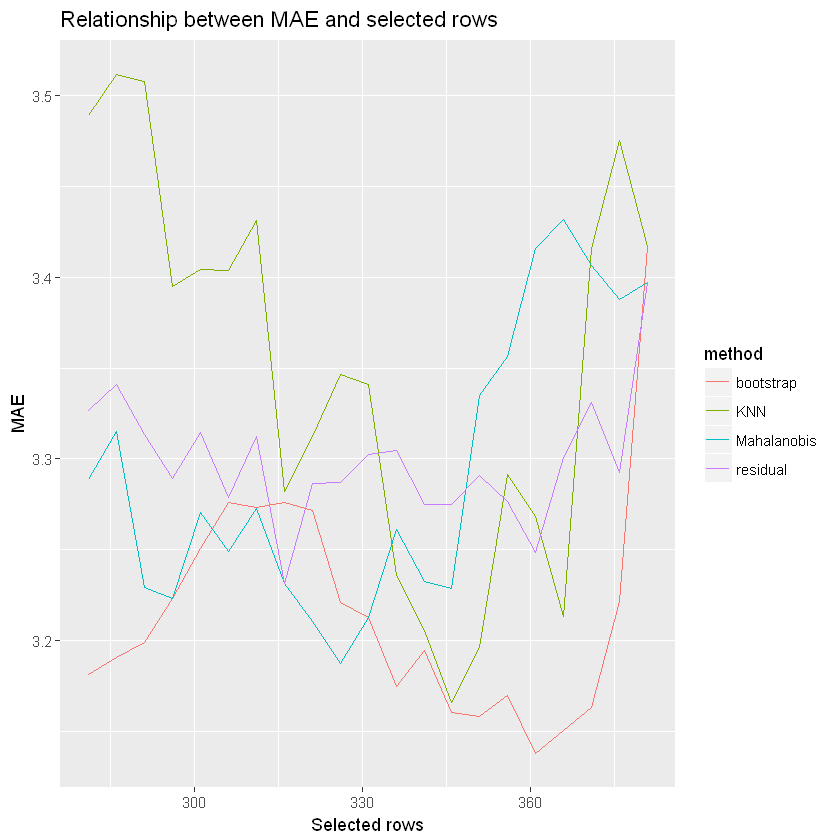

In [20]:
p=ggplot(df, aes(x=nrows, y=MAE, color=method)) +geom_line()+
  labs(title="Relationship between MAE and selected rows",
        x ="Selected rows", y = "MAE")
p

*We can see that the row selection based on information achieved during bootstrapping achieves the best results.

*Row selection based on residuals shows much worse performance in testing data. This is an indicator that there is some overfitting of noise during model training and the model is trying to accurately fit noisy rows.

*Row selection based on KNN also achieves good results. However, the trend is much more inconsistent. We should take into account that model training should not be based on test data information so the selection of rows should be based on rows behaving as outliers. The selection of the number of rows to remove should be based on applying methods such as the function outlier.stats. These methods will give worse performance with inconsistent trends.

Let's find the mean bootstrap_residual_stats which behave as outliers and see how the difference between the MAE with all rows and the selected rows is reduced.

In [68]:
row_number_to_keep=length(which(bootstrap_residual_stats$mean<=boxplot.stats(bootstrap_residual_stats$mean)$stats[5]))
paste("Rows selected: ",row_number_to_keep)
error_order=order(bootstrap_residual_stats$mean)
MAE_all_rows=fr(no_rows_sequence[1])
MAE_selected_rows=fr(row_number_to_keep)
paste("MAE with all rows:",MAE_all_rows)
paste("MAE with selected rows:",MAE_selected_rows)
paste("% decrease",100*(MAE_selected_rows/MAE_all_rows-1))

[1] "Rows selected:  348"

[1] "MAE with all rows: 3.4357095034663"

[1] "MAE with selected rows: 3.18017772252628"

[1] "% decrease -7.43752580601519"

So we have reduced the error 7% without the need of fancy computationally intensive algorithms or of exhaustive post-hoc and data dredging prone analyses.

# Row selection in test data (yeah, really)

So it seems we have reduced a 7% the error during prediction thanks to being able to detect which rows add noise to be overfit and create non-generalizable information.

Ok, let's stop a moment and think about what it means to have found rows to remove in the training data: it means that we also have error in the test data which is distorting our evaluation of the quality of our model. Our model would be better predicting than we are aware of.

How to find te noise in the test data? Well, we can do the same process than with the training data: we can carete a model during bootstrapping and evaluate which rows gave higher error during the iterations.

In [57]:
set.seed(1);test_model <- train(medv ~ . ,
               data = BostonHousing[-train_ind,],
               preProcess = c("center", "scale"),
               method = "lasso",
               metric="MAE",
               tuneLength = 10,
               trControl = trainControl(method = "boot632",number=1000,
                                        savePredictions = "all"))
test_model

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample0004: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample0177: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample0348: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in preProcess.default(thresh = 0.95, k = 5, freq

The lasso 

125 samples
 13 predictor

Pre-processing: centered (13), scaled (13) 
Resampling: Bootstrapped (1000 reps) 
Summary of sample sizes: 125, 125, 125, 125, 125, 125, ... 
Resampling results across tuning parameters:

  fraction   RMSE      Rsquared   MAE     
  0.1000000  6.859995  0.6156227  5.167117
  0.1888889  5.757482  0.6443806  4.446365
  0.2777778  5.078655  0.6822006  3.926126
  0.3666667  4.794751  0.6992375  3.664107
  0.4555556  4.668190  0.7135033  3.568376
  0.5444444  4.594756  0.7213405  3.507981
  0.6333333  4.554275  0.7259424  3.470836
  0.7222222  4.528801  0.7288102  3.443660
  0.8111111  4.516695  0.7302756  3.428913
  0.9000000  4.519535  0.7303300  3.424980

MAE was used to select the optimal model using the smallest value.
The final value used for the model was fraction = 0.9.

In [58]:
test_model$pred$MAE=abs(test_model$pred$pred-test_model$pred$obs)

test_bootstrap_residual_stats = test_model$pred %>%
group_by(rowIndex) %>%
summarise(mean = mean(MAE,na.rm=T),sd=sd(MAE,na.rm=T))
summary(test_bootstrap_residual_stats)

    rowIndex        mean               sd        
 Min.   :  1   Min.   : 0.7316   Min.   :0.5397  
 1st Qu.: 32   1st Qu.: 2.0397   1st Qu.:1.2014  
 Median : 63   Median : 3.0429   Median :1.6483  
 Mean   : 63   Mean   : 3.9644   Mean   :1.8561  
 3rd Qu.: 94   3rd Qu.: 4.9867   3rd Qu.:2.2033  
 Max.   :125   Max.   :13.9014   Max.   :5.2844  

Now we can evaluate if row selection  in the test dataset based on removing the rows with worse error can improve the results in the training dataset (we retrain 'test_model' to ensure the number of bootstrap iterations does not play a role):

In [65]:
idx_to_keep=which(new_bootstrap_residual_stats$mean<=boxplot.stats(new_bootstrap_residual_stats$mean)$stats[5])
paste("Rows selected: ",length(idx_to_keep))

set.seed(1);test_model=train(medv ~ . ,
                             data = BostonHousing[-train_ind,],
                             preProcess = c("center", "scale"),
                             method = "lasso",
                             metric="MAE",
                             tuneLength = 10,
                             trControl = trainControl(method = "boot632",
                                                      savePredictions = "all"))

dummy=MAE(pred = predict(test_model,BostonHousing[train_ind,]),obs=BostonHousing$medv[train_ind])
paste("MAE with all rows:",dummy)
set.seed(1);test_model_2=train(medv ~ . ,
                             data = BostonHousing[-train_ind,][idx_to_keep,],
                             preProcess = c("center", "scale"),
                             method = "lasso",
                             metric="MAE",
                             tuneLength = 10,
                             trControl = trainControl(method = "boot632",
                                                      savePredictions = "all"))
dummy2=MAE(pred = predict(test_model_2,BostonHousing[train_ind,]),obs=BostonHousing$medv[train_ind])
paste("MAE with all selected:",dummy2)

paste("% decrease",100*(dummy2/dummy-1))

[1] "Rows selected:  116"

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: chas1"Warning message:
"model fit failed for Resample04: fraction=0.9 Error in elasticnet::enet(as.matrix(x), y, lambda = 0, ...) : 
  Some of the columns of x have zero variance
"Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

[1] "MAE with all rows: 3.56474294446306"

[1] "MAE with all selected: 3.44976003143164"

[1] "% decrease -3.22555973383768"

Now that we have checked that the row selection in the test dataset increases the quality of this dataset, we can used the edited test dataset to evaluate the actual improvement of the model after performing row selection in the training and the test datasets:

In [69]:
paste("MAE with all rows:",MAE_all_rows)
MAE_selected_train_test=rows=MAE(pred = predict(new_model,BostonHousing[-train_ind,][idx_to_keep,]),obs=BostonHousing$medv[-train_ind][idx_to_keep])

paste("MAE with selected rows:",MAE_selected_train_test)
paste("% decrease",100*(MAE_selected_train_test/MAE_all_rows-1))




[1] "MAE with all rows: 3.4357095034663"

[1] "MAE with selected rows: 2.54389271794976"

[1] "% decrease -25.9572814470137"

Wow, so only performing only a few easy automatics teps of row selection we have reduced the error more than 25%!

Well, conceptually, I think the improvement is not that high. The initial model was never that bad but its quality was hidden by the noise in the test dataset. A more accurate estimation of the decrease error achieved after row selection requires comparing results with the test dataset after row selection:

In [70]:
MAE_selected_test=rows=MAE(pred = predict(model,BostonHousing[-train_ind,][idx_to_keep,]),obs=BostonHousing$medv[-train_ind][idx_to_keep])

paste("MAE with all rows:",MAE_selected_test)
MAE_selected_train_test=rows=MAE(pred = predict(new_model,BostonHousing[-train_ind,][idx_to_keep,]),obs=BostonHousing$medv[-train_ind][idx_to_keep])

paste("MAE with selected rows:",MAE_selected_train_test)
paste("% decrease",100*(MAE_selected_train_test/MAE_selected_test-1))

[1] "MAE with all rows: 2.82632981119992"

[1] "MAE with selected rows: 2.54389271794976"

[1] "% decrease -9.99306917865537"

So we have achieved an actual 10% decrease in the error thanks to the automatic row selection method applied.

## Next steps

*Theoretically, this row selection method should be easily applied for classification models through the evaluation of the confusion matrix for each row.

*This approach seems especially promising for non-tabular or highly categorical datasets. Typical methods to evaluate outliers are based on numeric approaches which are not easy to translate to this kinds of datasets.

*Image or NLP problems, where a huge amount of time might need to be spent labeling correctly the datasets, might be hugely benefited by this kind of approach. Semisupervised approaches to expand datasets consist of using a small correctly labelled  dataset to predict the label in a huge dataset so to expand the dataset to be used during model training. However, these approaches have the tradeoff of adding noise to the dataset through wrong labelling during prediction. Performing image selection based on wrong labelling during bootstrapped modelling in the training dataset might help achieve much more generalizable models.
